# Check Resource

In [32]:
!pip install pandas transformers torch tqdm sastrawi deep-translator

In [33]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

No GPU available, using the CPU instead


In [34]:
from google.colab import files
uploaded = files.upload()

import io
import pandas as pd

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  # Assuming the uploaded file is a CSV
  try:
    df_article = pd.read_csv(io.BytesIO(uploaded[fn]))
    print("Successfully loaded CSV into df_okejek")
  except pd.errors.ParserError:
      print(f"Error: Could not parse {fn} as a CSV. Please upload a valid CSV file.")
      df_article = pd.DataFrame() # Create an empty DataFrame if parsing fails
  except Exception as e:
    print(f"An unexpected error occurred: {e}")
    df_article = pd.DataFrame()


Saving articles_raw.csv to articles_raw (1).csv
User uploaded file "articles_raw (1).csv" with length 479671 bytes
Successfully loaded CSV into df_okejek


In [35]:
df_article.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Kategori       135 non-null    object
 1   Link           153 non-null    object
 2   article_title  153 non-null    object
 3   article_text   153 non-null    object
dtypes: object(4)
memory usage: 4.9+ KB


# Pre-Process

In [36]:
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import string
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Data Preparation

In [37]:
df_article.dropna(subset=['article_text'], inplace=True)
df_article['article_text'] = df_article['article_text'].astype(str)

print(df_article.head())

      Kategori                                               Link  \
0      Finance  https://industri.kontan.co.id/news/pemerintah-...   
1     Incident  https://news.okezone.com/read/2023/10/29/337/2...   
2     Incident  https://www.cnnindonesia.com/ekonomi/202306081...   
3     Incident  https://www.antaranews.com/video/3366141/ini-d...   
4  Operational  https://haji.kemenag.go.id/v5/detail/tingkatka...   

                                       article_title  \
0  Pemerintah Resmi Turunkan Harga Tiket Pesawat,...   
1  Peristiwa 29 Oktober : Pesawat Lion Air Jatuh ...   
2  Deret Masalah Penerbangan Lion Air Group Sepan...   
3  Ini dugaan penyebab kecelakaan pesawat Lion Ai...   
4  Tingkatkan Kualitas Layanan, Kemenag - Lion Ai...   

                                        article_text  
0  Reporter: Leni Wandira | Editor: Wahyu T.Rahma...  
1  SEJUMLAH peristiwa terjadi pada 29 Oktober. Sa...  
2  Sekretaris Umum PP Muhammadiyah Abdul Mu'ti me...  
3  Copyright © ANTARA 2023\n

## Data Cleaning

In [38]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Hapus URL
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Hapus Mention
    text = re.sub(r'@\w+', '', text)
    # Hapus Angka
    text = re.sub(r'\d+', '', text)
    # Hapus Tanda Baca
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Hapus Spasi Berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

## Sentiment Polarity

In [39]:
import pandas as pd
from textblob import TextBlob
from deep_translator import GoogleTranslator
import time

def analyze_long_text_sentiment(text):
    # Jika teksnya pendek, langsung proses
    if len(text) < 5000:
        try:
            translated_text = GoogleTranslator(source='id', target='en').translate(text)
            blob = TextBlob(translated_text)
            return pd.Series([blob.sentiment.polarity, blob.sentiment.subjectivity])
        except Exception as e:
            print(f"Terjadi error pada teks pendek: {e}")
            return pd.Series([None, None])

    # Jika teks panjang, pecah menjadi beberapa bagian
    else:
        try:
            max_chunk_size = 4500
            chunks = [text[i:i+max_chunk_size] for i in range(0, len(text), max_chunk_size)]

            translated_chunks = []
            for i, chunk in enumerate(chunks):
                time.sleep(0.5)
                translated_chunks.append(
                    GoogleTranslator(source='id', target='en').translate(chunk)
                )

            # Gabungkan kembali semua hasil terjemahan
            full_translated_text = ' '.join(translated_chunks)

            # Analisis sentimen dari teks lengkap yang sudah diterjemahkan
            blob = TextBlob(full_translated_text)
            return pd.Series([blob.sentiment.polarity, blob.sentiment.subjectivity])

        except Exception as e:
            print(f"Terjadi error pada saat memproses teks panjang: {e}")
            return pd.Series([None, None])


# Terapkan FUNGSI BARU ini ke DataFrame Anda
df_article[['polarity', 'subjectivity']] = df_article['article_text'].apply(analyze_long_text_sentiment)

print(df_article[['article_text', 'polarity', 'subjectivity']].head())


                                        article_text  polarity  subjectivity
0  Reporter: Leni Wandira | Editor: Wahyu T.Rahma...  0.064323      0.314263
1  SEJUMLAH peristiwa terjadi pada 29 Oktober. Sa...  0.157407      0.348148
2  Sekretaris Umum PP Muhammadiyah Abdul Mu'ti me...  0.016378      0.325558
3  Copyright © ANTARA 2023\nDilarang keras mengam...  0.000000      0.000000
4  21 Feb 2025 oleh Husni Anggoro | dilihat 42259...  0.132021      0.436067


## Tokenize

In [40]:
def tokenize_text(text):
    return word_tokenize(text)

## Stopwords Removal

In [41]:
list_stopwords = stopwords.words('indonesian')

def remove_stopwords(tokens, stopwords_list):
    return [word for word in tokens if word not in stopwords_list]

## Stemming

In [42]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(tokens):
    return [stemmer.stem(word) for word in tokens]

## Apply Pre-Processing

In [43]:
# Terapkan cleaning dan tokenisasi
df_article['text_cleaned'] = df_article['article_text'].apply(clean_text)
df_article['tokens'] = df_article['text_cleaned'].apply(tokenize_text)

# Hapus stopwords default
df_article['tokens_no_stop'] = df_article['tokens'].apply(lambda x: remove_stopwords(x, list_stopwords))

print("\nDataFrame setelah cleaning, tokenisasi, dan penghapusan stopword awal:")
print(df_article[['article_text', 'tokens_no_stop']].head())

all_tokens = [word for tokens in df_article['tokens_no_stop'] for word in tokens]

from nltk.probability import FreqDist
freq_dist = FreqDist(all_tokens)

print("\n20 Kata Paling Umum:")
print(freq_dist.most_common(20))


DataFrame setelah cleaning, tokenisasi, dan penghapusan stopword awal:
                                        article_text  \
0  Reporter: Leni Wandira | Editor: Wahyu T.Rahma...   
1  SEJUMLAH peristiwa terjadi pada 29 Oktober. Sa...   
2  Sekretaris Umum PP Muhammadiyah Abdul Mu'ti me...   
3  Copyright © ANTARA 2023\nDilarang keras mengam...   
4  21 Feb 2025 oleh Husni Anggoro | dilihat 42259...   

                                      tokens_no_stop  
0  [reporter, leni, wandira, editor, wahyu, trahm...  
1  [peristiwa, oktober, salah, satunya, jatuhnya,...  
2  [sekretaris, pp, muhammadiyah, abdul, muti, me...  
3  [copyright, ©, dilarang, keras, mengambil, kon...  
4  [feb, husni, anggoro, kali, jakarta, phu, dire...  

20 Kata Paling Umum:
[('pesawat', 1070), ('air', 1012), ('lion', 1010), ('penerbangan', 614), ('penumpang', 566), ('bandara', 457), ('danang', 251), ('baca', 247), ('maskapai', 211), ('udara', 208), ('jt', 205), ('berita', 189), ('september', 182), ('indonesia

In [44]:
custom_stopwords = ['klik']

final_stopwords = list_stopwords + custom_stopwords

df_article['tokens_final'] = df_article['tokens'].apply(lambda x: remove_stopwords(x, final_stopwords))

df_article['tokens_stemmed'] = df_article['tokens_final'].apply(stem_text)

print("\nDataFrame Hasil Akhir Setelah Custom Stopword & Stemming:")
# Tampilkan kolom-kolom relevan untuk perbandingan
print(df_article[['article_text', 'tokens_stemmed']].head())

# Anda juga bisa menyimpan hasil akhir sebagai string jika diperlukan
df_article['text_final'] = df_article['tokens_stemmed'].apply(lambda x: ' '.join(x))

print("\nKolom Teks Final (String):")
print(df_article[['article_text', 'text_final']].head())


DataFrame Hasil Akhir Setelah Custom Stopword & Stemming:
                                        article_text  \
0  Reporter: Leni Wandira | Editor: Wahyu T.Rahma...   
1  SEJUMLAH peristiwa terjadi pada 29 Oktober. Sa...   
2  Sekretaris Umum PP Muhammadiyah Abdul Mu'ti me...   
3  Copyright © ANTARA 2023\nDilarang keras mengam...   
4  21 Feb 2025 oleh Husni Anggoro | dilihat 42259...   

                                      tokens_stemmed  
0  [reporter, leni, wandira, editor, wahyu, trahm...  
1  [peristiwa, oktober, salah, satu, jatuh, pesaw...  
2  [sekretaris, pp, muhammadiyah, abdul, muti, kr...  
3  [copyright, , larang, keras, ambil, konten, cr...  
4  [feb, husni, anggoro, kali, jakarta, phu, dire...  

Kolom Teks Final (String):
                                        article_text  \
0  Reporter: Leni Wandira | Editor: Wahyu T.Rahma...   
1  SEJUMLAH peristiwa terjadi pada 29 Oktober. Sa...   
2  Sekretaris Umum PP Muhammadiyah Abdul Mu'ti me...   
3  Copyright © ANTARA 

# Frequent words Analysis

## WordCloud

sentiment label

In [45]:
def get_sentiment_label_from_polarity(polarity):
    if polarity > 0.05:
        return 'Positive'
    elif polarity < -0.05:
        return 'Negative'
    else:
        return 'Netral'

df_article['polarity'].fillna(0, inplace=True)
df_article['sentiment_label'] = df_article['polarity'].apply(get_sentiment_label_from_polarity)

print("DataFrame dengan kolom label sentimen baru:")
print(df_article[['article_text', 'polarity', 'sentiment_label']].head())

DataFrame dengan kolom label sentimen baru:
                                        article_text  polarity sentiment_label
0  Reporter: Leni Wandira | Editor: Wahyu T.Rahma...  0.064323        Positive
1  SEJUMLAH peristiwa terjadi pada 29 Oktober. Sa...  0.157407        Positive
2  Sekretaris Umum PP Muhammadiyah Abdul Mu'ti me...  0.016378          Netral
3  Copyright © ANTARA 2023\nDilarang keras mengam...  0.000000          Netral
4  21 Feb 2025 oleh Husni Anggoro | dilihat 42259...  0.132021        Positive


/tmp/ipython-input-1081228074.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_article['polarity'].fillna(0, inplace=True)


In [46]:
positive_articles_df = df_article[df_article['sentiment_label'] == 'Positive']
negative_articles_df = df_article[df_article['sentiment_label'] == 'Negative']

print(f"\nJumlah artikel Positif: {len(positive_articles_df)}")
print(f"Jumlah artikel Negatif: {len(negative_articles_df)}")

positive_text = ' '.join(positive_articles_df['article_text'])
negative_text = ' '.join(negative_articles_df['article_text'])


Jumlah artikel Positif: 92
Jumlah artikel Negatif: 14


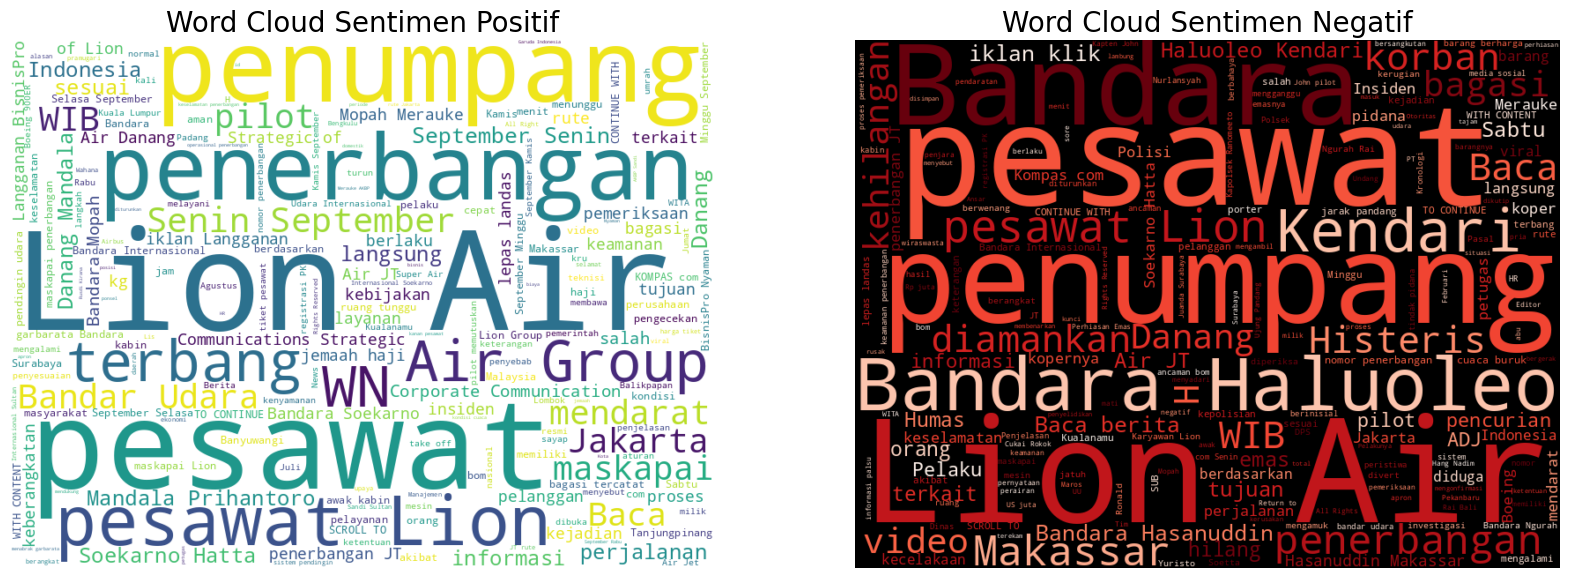

In [47]:
# --- Langkah 3: Generate dan Tampilkan Word Cloud ---
plt.figure(figsize=(20, 10))

# Word Cloud Positif
if positive_text:
    plt.subplot(1, 2, 1)
    wordcloud_positive = WordCloud(
        stopwords=list_stopwords, # Gunakan stopwords untuk membersihkan teks
        width=800,
        height=600,
        background_color='white',
        colormap='viridis'
    ).generate(positive_text)
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.title('Word Cloud Sentimen Positif', fontsize=20)
    plt.axis('off')

# Word Cloud Negatif
if negative_text:
    plt.subplot(1, 2, 2)
    wordcloud_negative = WordCloud(
        stopwords=list_stopwords, # Gunakan stopwords untuk membersihkan teks
        width=800,
        height=600,
        background_color='black',
        colormap='Reds'
    ).generate(negative_text)
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.title('Word Cloud Sentimen Negatif', fontsize=20)
    plt.axis('off')

plt.show()